## Documentation

To read more about the search after parameter, checkout the docs [here](https://www.elastic.co/guide/en/elasticsearch/reference/8.15/paginate-search-results.html#search-after).

![search_after_docs](../images/search_after_docs.png)

## Connect to ElasticSearch

In [1]:
from pprint import pprint
from elasticsearch import Elasticsearch

es = Elasticsearch('http://localhost:9200')
client_info = es.info()
print('Connected to Elasticsearch!')
pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'WpOI-sfBSXe9aaVkWGIQnQ',
 'name': '61929d733ddf',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2025-12-16T10:09:08.849001802Z',
             'build_flavor': 'default',
             'build_hash': 'd8972a71dbbd64ff17f2f4dba9ca2c3fe09fb100',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '10.3.2',
             'minimum_index_compatibility_version': '8.0.0',
             'minimum_wire_compatibility_version': '8.19.0',
             'number': '9.2.3'}}


## Preparing the index

The `timestamp` field is useful for sorting documents, which is essential for the `search_after` parameter. Alternatively, you can use the document ID for sorting as well.

In [2]:
index_name = 'my_index'
mapping = {
    "mappings": {
        "properties": {
            "timestamp": {"type": "date"},
            "value": {"type": "float"},
            "category": {"type": "keyword"},
            "description": {"type": "text"},
            "id": {"type": "keyword"},
        }
    },
}

es.indices.delete(index=index_name, ignore_unavailable=True)
es.indices.create(index=index_name, body=mapping)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

## Generating fake data

The base documents will be duplicated to create a total of `100,000` documents. This is done to compare the `from/size` method with the `search_after` method.

In [3]:
base_documents = [
    {
        "category": "A",
        "value": 100,
        "description": "First sample document"
    },
    {
        "category": "B",
        "value": 200,
        "description": "Second sample document"
    },
    {
        "category": "C",
        "value": 300,
        "description": "Third sample document"
    },
    {
        "category": "D",
        "value": 400,
        "description": "Fourth sample document"
    },
    {
        "category": "E",
        "value": 500,
        "description": "Fifth sample document"
    }
]

The `generate_bulk_data` function determines the number of times to duplicate the base documents to achieve a target of `100,000` documents. It also assigns a unique `_id`, modifies the `value` field randomly, and appends a `timestamp` to each duplicated document.

In [4]:
import random

from datetime import datetime, timedelta


def generate_bulk_data(base_documents, target_size=100_000):
    documents = []
    base_count = len(base_documents)
    duplications_needed = target_size // base_count

    base_timestamp = datetime.now()

    for i in range(duplications_needed):
        for document in base_documents:
            new_doc = document.copy()
            new_doc['id'] = f"doc_{len(documents)}"
            new_doc['timestamp'] = (
                base_timestamp - timedelta(minutes=len(documents))).isoformat()
            new_doc['value'] = document['value'] + random.uniform(-10, 10)
            documents.append(new_doc)

    return documents


documents = generate_bulk_data(base_documents, target_size=100_000)
print(f"Generated {len(documents)} documents")

Generated 100000 documents


## Indexing

In [5]:
from tqdm import tqdm

operations = []
for document in tqdm(documents, total=len(documents)):
    operations.append({'index': {'_index': index_name}})
    operations.append(document)

response = es.bulk(operations=operations)
pprint(response.body["errors"])

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:00<00:00, 938843.92it/s]


False


In [6]:
es.indices.refresh(index=index_name)

count = es.count(index=index_name)["count"]
print(f"Indexed {count} documents")

Indexed 100000 documents


## From / Size method

To use the `from/size` method, include two parameters in your query: `from`, which specifies the number of documents to skip, and `size`, which tells Elasticsearch how many documents to return.

In [7]:
response = es.search(
    index=index_name,
    body={
        "from": 0,
        "size": 10,
        "sort": [
            {"timestamp": "desc"},
            {"id": "desc"}
        ]
    }
)

hits = response["hits"]["hits"]
for hit in hits:
    print(f"ID: {hit['_source']['id']}")

ID: doc_0
ID: doc_1
ID: doc_2
ID: doc_3
ID: doc_4
ID: doc_5
ID: doc_6
ID: doc_7
ID: doc_8
ID: doc_9


To retrieve the next batch of documents, adjust the `from` parameter from 0 to 10.

In [8]:
response = es.search(
    index=index_name,
    body={
        "from": 10,
        "size": 10,
        "sort": [
            {"timestamp": "desc"},
            {"id": "desc"}
        ]
    }
)

hits = response["hits"]["hits"]
for hit in hits:
    print(f"ID: {hit['_source']['id']}")

ID: doc_10
ID: doc_11
ID: doc_12
ID: doc_13
ID: doc_14
ID: doc_15
ID: doc_16
ID: doc_17
ID: doc_18
ID: doc_19


## Search after method

To use the `search_after` method, include the following parameters in your query:

1. **size**: Specifies the number of documents to retrieve in each batch, similar to the `size` parameter in `from/size`.

2. **sort**: The `search_after` method requires specifying one or more fields to sort the results, such as `timestamp` or `id`. Sorting ensures a consistent order for navigating through result pages.

In [9]:
response = es.search(
    index=index_name,
    body={
        "size": 10,
        "sort": [
            {"timestamp": "desc"},
            {"id": "desc"}
        ]
    }
)

hits = response["hits"]["hits"]
for hit in hits:
    print(f"ID: {hit['_source']['id']}")
    print(f"Sort values: {hit['sort']}")
    print()

ID: doc_0
Sort values: [1769625218250, 'doc_0']

ID: doc_1
Sort values: [1769625158250, 'doc_1']

ID: doc_2
Sort values: [1769625098250, 'doc_2']

ID: doc_3
Sort values: [1769625038250, 'doc_3']

ID: doc_4
Sort values: [1769624978250, 'doc_4']

ID: doc_5
Sort values: [1769624918250, 'doc_5']

ID: doc_6
Sort values: [1769624858250, 'doc_6']

ID: doc_7
Sort values: [1769624798250, 'doc_7']

ID: doc_8
Sort values: [1769624738250, 'doc_8']

ID: doc_9
Sort values: [1769624678250, 'doc_9']



To retrieve the next batch of documents using `search_after`, you’ll pass the `sort` values from the last document of the previous batch to the `search_after` parameter in the subsequent query.

In [10]:
last_sort_values = hits[-1]["sort"]
response = es.search(
    index=index_name,
    body={
        "size": 10,
        "sort": [
            {"timestamp": "desc"},
            {"id": "desc"}
        ],
        "search_after": last_sort_values
    }
)

hits = response["hits"]["hits"]
for hit in hits:
    print(f"ID: {hit['_source']['id']}")
    print(f"Sort values: {hit['sort']}")
    print()

ID: doc_10
Sort values: [1769624618250, 'doc_10']

ID: doc_11
Sort values: [1769624558250, 'doc_11']

ID: doc_12
Sort values: [1769624498250, 'doc_12']

ID: doc_13
Sort values: [1769624438250, 'doc_13']

ID: doc_14
Sort values: [1769624378250, 'doc_14']

ID: doc_15
Sort values: [1769624318250, 'doc_15']

ID: doc_16
Sort values: [1769624258250, 'doc_16']

ID: doc_17
Sort values: [1769624198250, 'doc_17']

ID: doc_18
Sort values: [1769624138250, 'doc_18']

ID: doc_19
Sort values: [1769624078250, 'doc_19']



## Benchmark

In this benchmark, we assess the performance of two pagination methods, `from/size` and `search_after`, by measuring and comparing their response times. We capture the response time of each method for multiple pages, plot the results, and calculate relevant statistics to provide insights.

### 1. From / Size test

In [11]:
import time

from tqdm import tqdm


def test_from_size_pagination(es, index_name, page_size=100, max_pages=50):
    timings = []

    for page in tqdm(range(max_pages)):
        start_time = time.time()

        _ = es.search(
            index=index_name,
            body={
                "from": page * page_size,
                "size": page_size,
                "sort": [
                    {"timestamp": "desc"},
                    {"id": "desc"}
                ]
            }
        )

        end_time = time.time()
        final_time = (end_time - start_time) * 1000
        timings.append((page + 1, final_time))

    return timings

When attempting to retrieve more than 10,000 documents, Elasticsearch returns an error indicating that the `from / size` method cannot handle this request.

In [12]:
from_size_timings = test_from_size_pagination(
    es=es,
    index_name=index_name,
    page_size=1000,
    max_pages=50
)

 20%|██        | 10/50 [00:00<00:00, 97.23it/s]


BadRequestError: BadRequestError(400, 'search_phase_execution_exception', 'Result window is too large, from + size must be less than or equal to: [10000] but was [11000]. See the scroll api for a more efficient way to request large data sets. This limit can be set by changing the [index.max_result_window] index level setting.', Result window is too large, from + size must be less than or equal to: [10000] but was [11000]. See the scroll api for a more efficient way to request large data sets. This limit can be set by changing the [index.max_result_window] index level setting.)

Let's reduce the `page_size` to avoid this problem.

In [13]:
from_size_timings = test_from_size_pagination(
    es=es,
    index_name=index_name,
    page_size=200,
    max_pages=50
)

100%|██████████| 50/50 [00:00<00:00, 217.75it/s]


### 2. Search after test

In [14]:
def test_search_after_pagination(es, index_name, page_size=100, max_pages=50):
    timings = []
    search_after = None

    for page in tqdm(range(max_pages)):
        start_time = time.time()

        body = {
            "size": page_size,
            "sort": [
                {"timestamp": "desc"},
                {"id": "desc"}
            ]
        }

        if search_after:
            body["search_after"] = search_after

        response = es.search(
            index=index_name,
            body=body
        )

        hits = response["hits"]["hits"]
        if hits:
            search_after = hits[-1]["sort"]

        end_time = time.time()
        final_time = (end_time - start_time) * 1000
        timings.append((page + 1, final_time))

    return timings

In [15]:
search_after_timings = test_search_after_pagination(
    es, index_name, page_size=200, max_pages=50)

100%|██████████| 50/50 [00:00<00:00, 348.69it/s]


### 3. Plotting & statistics

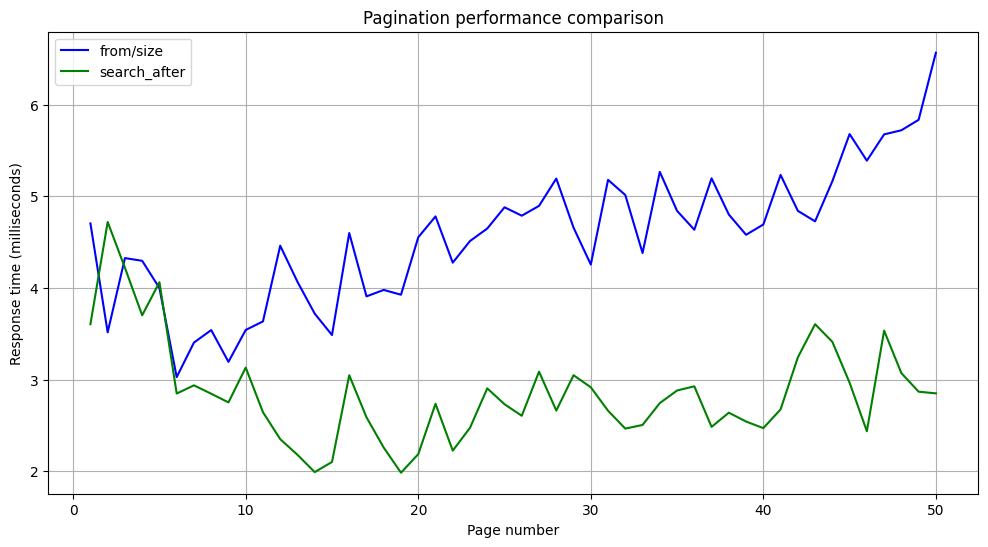

In [17]:
import matplotlib.pyplot as plt


def plot_comparison(from_size_timings, search_after_timings):
    plt.figure(figsize=(12, 6))

    pages_from_size, times_from_size = zip(*from_size_timings)
    pages_search_after, times_search_after = zip(*search_after_timings)

    plt.plot(pages_from_size, times_from_size, 'b-', label='from/size')
    plt.plot(pages_search_after, times_search_after,
             'g-', label='search_after')

    plt.xlabel('Page number')
    plt.ylabel('Response time (milliseconds)')
    plt.title('Pagination performance comparison')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_comparison(from_size_timings, search_after_timings)

The `search_after` method performs more efficiently, especially for deep pagination, due to its stable response time. In contrast, `from/size` may be suitable for shallow pagination but becomes inefficient as the page depth grows.

In [18]:
def calculate_stats(from_size_timings, search_after_timings):
    _, times_from_size = zip(*from_size_timings)
    _, times_search_after = zip(*search_after_timings)

    stats = {
        'from_size': {
            'avg_time': sum(times_from_size) / len(times_from_size),
            'max_time': max(times_from_size),
            'min_time': min(times_from_size)
        },
        'search_after': {
            'avg_time': sum(times_search_after) / len(times_search_after),
            'max_time': max(times_search_after),
            'min_time': min(times_search_after)
        }
    }
    return stats


stats = calculate_stats(from_size_timings, search_after_timings)

print("\nPerformance statistics:")
print("\n- From/Size pagination:")
print(f"Average time: {stats['from_size']['avg_time']:.3f} milliseconds")
print(f"Maximum time: {stats['from_size']['max_time']:.3f} milliseconds")
print(f"Minimum time: {stats['from_size']['min_time']:.3f} milliseconds")

print("\n- Search after pagination:")
print(f"Average time: {stats['search_after']['avg_time']:.3f} milliseconds")
print(f"Maximum time: {stats['search_after']['max_time']:.3f} milliseconds")
print(f"Minimum time: {stats['search_after']['min_time']:.3f} milliseconds")


Performance statistics:

- From/Size pagination:
Average time: 4.565 milliseconds
Maximum time: 6.567 milliseconds
Minimum time: 3.028 milliseconds

- Search after pagination:
Average time: 2.851 milliseconds
Maximum time: 4.720 milliseconds
Minimum time: 1.985 milliseconds


These statistics validate that `search_after` is the preferable pagination method for consistent and scalable performance.

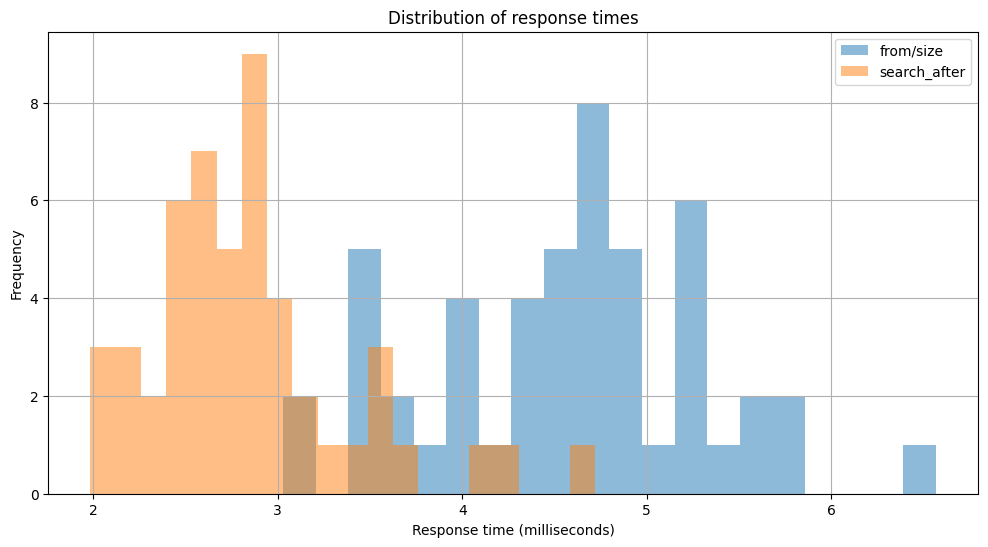

In [19]:
plt.figure(figsize=(12, 6))
_, times_from_size = zip(*from_size_timings)
_, times_search_after = zip(*search_after_timings)

plt.hist(times_from_size, alpha=0.5, label='from/size', bins=20)
plt.hist(times_search_after, alpha=0.5, label='search_after', bins=20)
plt.xlabel('Response time (milliseconds)')
plt.ylabel('Frequency')
plt.title('Distribution of response times')
plt.legend()
plt.grid(True)
plt.show()

Based on this histogram visualization, the `search_after` approach (shown in orange) demonstrates consistently faster response times clustered around 2-5 milliseconds, while the `from/size` method (in blue) shows a wider distribution of response times spreading up to 16 milliseconds, suggesting that `search_after` provides more predictable and generally better performance for pagination.

In [20]:
def calculate_degradation(timings):
    first_page_time = timings[0][1]
    last_page_time = timings[-1][1]
    degradation_factor = last_page_time / first_page_time
    return degradation_factor


from_size_degradation = calculate_degradation(from_size_timings)
search_after_degradation = calculate_degradation(search_after_timings)

print("\nPerformance degradation (Last page time / First page time):")
print(f"- From/Size degradation factor   : {from_size_degradation:.2f}x")
print(f"- Search after degradation factor: {search_after_degradation:.2f}x")


Performance degradation (Last page time / First page time):
- From/Size degradation factor   : 1.40x
- Search after degradation factor: 0.79x


The `search_after` method is far superior in maintaining a stable response time, even for large page numbers. In contrast, `from/size` exhibits significant performance degradation, making it less suitable for deep pagination.


## Conclusion

For larger indexes, it's recommended to use the `search_after` method. For smaller indexes, both methods work well.